In [1]:
import keras
import sklearn.utils.class_weight
from keras.layers import Dropout, Flatten, Conv1D, MaxPooling1D, BatchNormalization
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight

import ecgclassification as ecgc
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from ecgclassification import linear_weight, multiclass_temporal_class_weights, precision_m, f1_m, recall_m
from ecgclassification.loss import *

db = 'ecgclassification/mitdb/'


data = ecgc.load_data_v2(db, classes='aami')




Loading beats took 29.3s
Loading the signals took: 9.9s


[https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras](here)

Classifier weighted CNN

c:\python39\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4], y=[0 0 0 ... 0 0 0] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


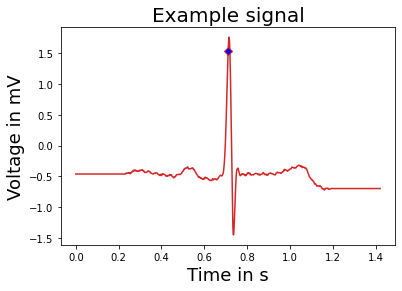

3
(65865, 1024, 1)
(21955, 1024)
(21956, 1024, 1)
(65865,)
(21955,)
(21956,)


In [2]:
#X_train, y_train = data['train'][0], data['train'][1]
#X_test, y_test = data['tests'][0], data['tests'][1]
#X_val, y_val = data['valid'][0], data['valid'][1]
X_train, X_test, y_train, y_test = train_test_split(data['data'][0], data['data'][1], test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.25, random_state=1)

cw = compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight = ecgc.linear_weight(y_train)
n_features = 1
n_classes = 5
batch_size = X_train.shape[0]
sequence_size = X_train.shape[1]
X_train = X_train.reshape([batch_size, sequence_size, 1])
ecgc.visualize_signal(X_train[0])
X_train = tf.convert_to_tensor(X_train)
X_val = tf.convert_to_tensor(X_val)
X_test = X_test.reshape([X_test.shape[0], X_test.shape[1], 1])
X_test = tf.convert_to_tensor(X_test)

y_train = tf.convert_to_tensor(y_train,dtype=np.float32)
y_test = tf.convert_to_tensor(y_test,dtype=np.float32)
y_val = tf.convert_to_tensor(y_val, dtype=np.float32)

print(X_train.ndim)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

input_shape = (None, sequence_size, n_features)

We will now print out the frequency of each class in the Training, Validation and Test set respectively

In [3]:
unique, counts = np.unique(y_train, return_counts=True)
print("Xtrain frequencies")
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_val, return_counts=True)
print("Xval frequencies")
print(dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Xtest frequencies")
print(dict(zip(unique, counts)))

Xtrain frequencies
{0.0: 54261, 1.0: 1695, 2.0: 4669, 3.0: 470, 4.0: 4770}
Xval frequencies
{0.0: 18078, 1.0: 554, 2.0: 1519, 3.0: 140, 4.0: 1664}
Xtest frequencies
{0.0: 18132, 1.0: 526, 2.0: 1513, 3.0: 192, 4.0: 1593}


Now that we have reshaped our data for the CNN we can define the layers and loss functions.

In [ ]:
model = Sequential()
model.add(Conv1D(
        input_shape = input_shape,
        filters=8,
        kernel_size=4,
        padding='same',
        activation='relu',
    ))
# batch normalization
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
#extra convolutional block
model.add(Conv1D(
        filters=8,
        kernel_size=4,
        padding='same',
        activation='relu',
    ))
# batch normalization
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(
        filters=8,
        kernel_size=4,
        padding='same',
        activation='relu',
    ))
# batch normalization
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dropout(0.5))
#output layers
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

loss = SparseCategoricalFocalLoss(gamma=1, from_logits=True)
#loss = keras.losses.SparseCategoricalCrossentropy()
#loss=f1_weighted()

metrics = [
    "categorical_accuracy",
    f1_m,
    precision_m,
    recall_m

]
model.compile(
    optimizer='nadam',
    loss=loss,
    metrics=metrics,
)

cw = {i : cw[i] for i in range(5)}
sample_weight = sklearn.utils.class_weight.compute_sample_weight(class_weight, y_train )
print(cw)
history = model.fit(X_train,
                    y_train,
                    epochs=30,
                    batch_size=32,
                    #sample_weight=sample_weight,
                    #class_weight=cw,
                    validation_data=(X_val, y_val),
                    verbose=2)
model.summary()

{0: 0.24277105103112734, 1: 7.771681415929203, 2: 2.821375026772328, 3: 28.027659574468085, 4: 2.761635220125786}
Epoch 1/30
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
2059/2059 - 84s - loss: 0.6185 - categorical_accuracy: 0.8769 - f1_m: 0.3065 - precision_m: 0.1837 - recall_m: 1.0363 - val_loss: 0.6004 - val_categorical_accuracy: 0.8768 - val_f1_m: 0.2980 - val_precision_m: 0.1788 - val_recall_m: 1.0088
Epoch 2/30
2059/2059 - 56s - loss: 0.6030 - categorical_accuracy: 0.8674 - f1_m: 0.2985 - precision_m: 0.1788 - recall_m: 1.0125 - val_loss: 0.6001 - val_categorical_accuracy: 0.8714 - val_f1_m: 0.2977 - val_precision_m: 0.1786 - val_recall_m: 1.0064
Epoch 3/30
2059/2059 - 62s - loss: 0.5990 - categorical_accuracy: 0.8656 - f1_m: 0.2970 - precision_m: 0.1779 - recall_m: 1.0078 - val_loss: 0.5923 - val_categorical_accuracy: 0.8638 - val_f1_m: 0.2957 - val_precision_m: 0.1774 - val_recall_m: 1.

In [ ]:
ecgc.evaluate_model(model, X_test, y_test, input_format='aami_num', keras_evaluation=True)

In [ ]:
model.save('models')